In [1]:
!pip install -q kagglehub
!pip install -q albumentations
!pip install -q torchmetrics

import kagglehub
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from torchmetrics.classification import BinaryAUROC
import matplotlib.pyplot as plt
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.nn.functional as F

from google.colab import files
import io



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Downloading the Dataset

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")




Organizing the Dataset into Directories

In [3]:
data_dir = path
train_dir = os.path.join(data_dir, "chest_xray/train")
val_dir = os.path.join(data_dir, "chest_xray/val")
test_dir = os.path.join(data_dir, "chest_xray/test")

Data Augmentation and Transformation

In [4]:
normal_aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.CLAHE(p=0.3),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
pneumonia_aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
basic_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

<ipython-input-4-2152ba0ed07b>:5: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Custom Dataset Class

In [5]:
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_normal=None, transform_pneumonia=None):
        self.data = []
        self.transform_normal = transform_normal
        self.transform_pneumonia = transform_pneumonia

        for label, folder in enumerate(["NORMAL", "PNEUMONIA"]):
            full_path = os.path.join(root_dir, folder)
            for img in os.listdir(full_path):
                self.data.append((os.path.join(full_path, img), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
          img_path, label = self.data[idx]
          image = Image.open(img_path).convert("RGB")
          image = np.array(image)

          if label == 0 and self.transform_normal:
              image = self.transform_normal(image=image)["image"]
          elif label == 1 and self.transform_pneumonia:
              image = self.transform_pneumonia(image=image)["image"]
          else:
              image = ToTensorV2(image=image)["image"]

          return image, label



Creating Dataset Instances

In [6]:
train_data = AlbumentationsDataset(
    train_dir,
    transform_normal=normal_aug,
    transform_pneumonia=pneumonia_aug
)


val_data = AlbumentationsDataset(
    val_dir,
    transform_normal=normal_aug,
    transform_pneumonia=pneumonia_aug
)

test_data = AlbumentationsDataset(
    test_dir,
    transform_normal=normal_aug,
    transform_pneumonia=pneumonia_aug
)

Calculating Class Weights

In [7]:
labels = [train_data[i][1] for i in range(len(train_data))]
class_sample_count = np.array([len([l for l in labels if l == t]) for t in [0, 1]])
weight = 1. / class_sample_count



samples_weight = np.array([weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))



Creating Data Loaders

In [8]:
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

Defining the Convolutional Neural Network (CNN)

In [9]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x





Creating and Moving the Model to GPU

In [10]:
model = PneumoniaCNN().cuda()

Device Selection and Model Transfer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaCNN().to(device)

Loss Function and Class Weights

In [12]:
weight_normal = 3.0
weight_pneumonia = 1.0

class_weights = torch.tensor([weight_normal, weight_pneumonia]).to(device)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

Optimizer and Learning Rate Scheduler

In [13]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)



Training Loop Initialization & Training Function

In [15]:
import torch
from google.colab import files

train_losses, val_losses, val_accuracies = [], [], []

# Initialize best accuracy
best_val_acc = 0.0

def train_model(model, epochs):
    global best_val_acc
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                val_loss += loss_fn(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Best model saved at epoch {epoch+1} with val accuracy: {val_acc:.4f}")

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

    # Download the best model after training completes
    files.download('best_model.pth')


Graph of Train Loss , Val Loss anD val Acuuracy

In [16]:
def plot_training():
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.legend()
    plt.title("Training Progress")
    plt.show()

accuracy of the model for each class (Normal and Pneumonia)

In [17]:

def class_accuracy():
    model.eval()
    correct = [0, 0]
    total = [0, 0]
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(2):
                correct[i] += ((preds == i) & (labels == i)).sum().item()
                total[i] += (labels == i).sum().item()
    for i, cls in enumerate(["Normal", "Pneumonia"]):
        print(f"{cls} Accuracy: {correct[i] / total[i]:.4f}")

 overall performance of the model on the test dataset

In [18]:
def evaluate_model():
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss += loss_fn(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Loss: {loss / len(test_loader):.4f}, Accuracy: {correct / total:.4f}")

more detailed evaluation of the model using a classification report and confusion matrix

In [19]:
def evaluate_model_on_test():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


plots the Precision-Recall (PR) curve and calculates the area under the curve (AUC) for the model.

In [20]:
def plot_roc_curve():
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            outputs = model(images)
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_scores.extend(scores)
            y_true.extend(labels.numpy())
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    plt.plot(recall, precision, label=f'PR AUC={pr_auc:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.title("PR Curve")
    plt.grid(True)
    plt.show()

displays a few sample prediction

In [21]:

def show_predictions(model, test_loader, device, n_per_class=3):

    model.eval()
    shown_normal = 0
    shown_pneumonia = 0
    total_required = n_per_class * 2

    plt.figure(figsize=(15, 6))
    class_names = ['NORMAL', 'PNEUMONIA']
    count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                actual = labels[i].item()
                if actual == 0 and shown_normal < n_per_class:
                    shown_normal += 1
                elif actual == 1 and shown_pneumonia < n_per_class:
                    shown_pneumonia += 1
                else:
                    continue

                pred = preds[i].item()
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * 0.5 + 0.5

                plt.subplot(2, n_per_class, count + 1)
                plt.imshow(np.clip(img, 0, 1))
                plt.title(f"Pred: {class_names[pred]}\nActual: {class_names[actual]}", fontsize=10)
                plt.axis("off")
                count += 1

                if count == total_required:
                    plt.tight_layout()
                    plt.show()
                    return


Best model saved at epoch 1 with val accuracy: 0.8125
Epoch 1: Train Loss 1.8244, Val Loss 0.3142, Val Acc 0.8125
Epoch 2: Train Loss 0.3353, Val Loss 0.3436, Val Acc 0.8125
Best model saved at epoch 3 with val accuracy: 0.9375
Epoch 3: Train Loss 0.2634, Val Loss 0.3045, Val Acc 0.9375
Epoch 4: Train Loss 0.2563, Val Loss 0.2548, Val Acc 0.9375
Epoch 5: Train Loss 0.2484, Val Loss 0.2842, Val Acc 0.9375
Epoch 6: Train Loss 0.2479, Val Loss 0.2315, Val Acc 0.9375
Epoch 7: Train Loss 0.2405, Val Loss 0.3236, Val Acc 0.9375
Best model saved at epoch 8 with val accuracy: 1.0000
Epoch 8: Train Loss 0.2314, Val Loss 0.2446, Val Acc 1.0000
Epoch 9: Train Loss 0.2341, Val Loss 0.2681, Val Acc 1.0000
Epoch 10: Train Loss 0.2431, Val Loss 0.2692, Val Acc 0.9375


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

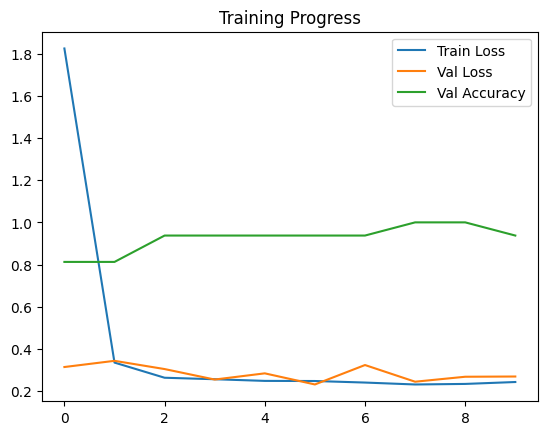

Test Loss: 0.4484, Accuracy: 0.8990
Normal Accuracy: 0.7949
Pneumonia Accuracy: 0.9615
Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.79      0.86       234
   Pneumonia       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

Confusion Matrix:
 [[186  48]
 [ 15 375]]
ROC AUC: 0.9676, PR AUC: 0.9782


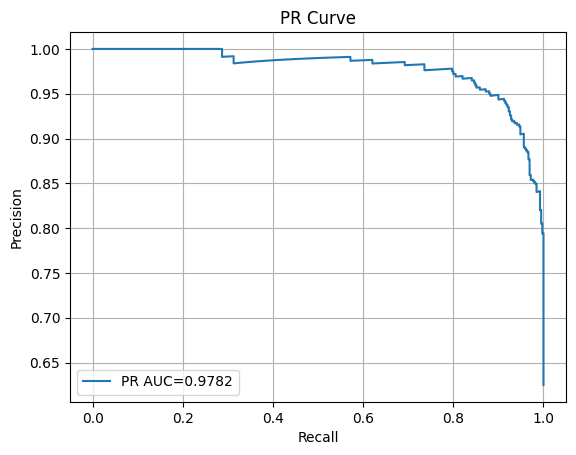

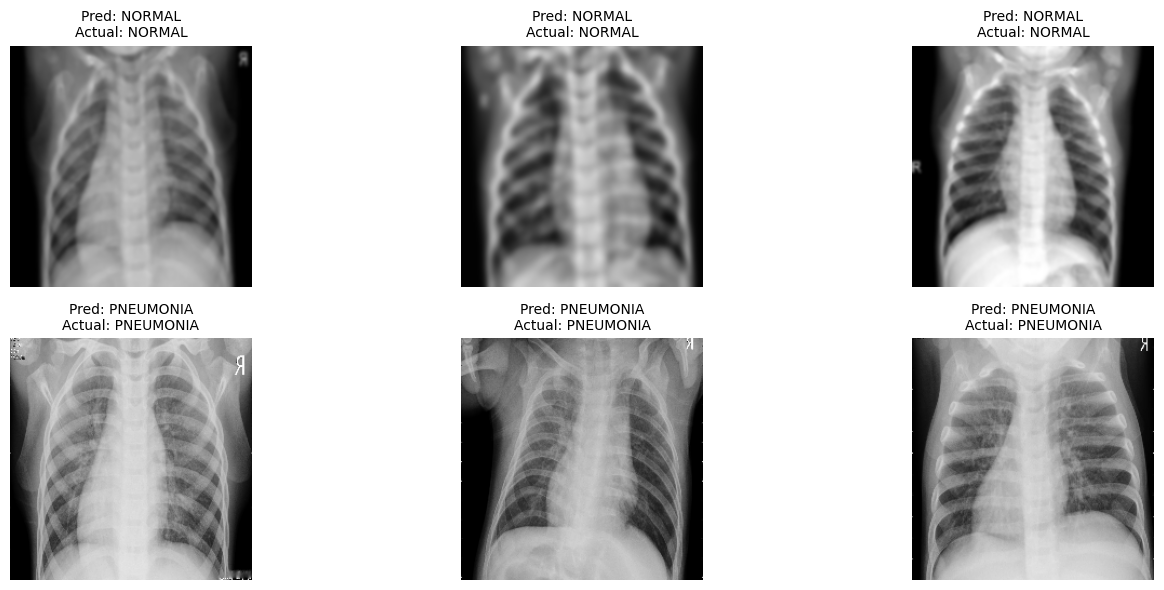

In [22]:
train_model(model, epochs=10)
plot_training()
evaluate_model()
class_accuracy()
evaluate_model_on_test()
plot_roc_curve()
show_predictions(model, test_loader, device)



Single image Prediction and Visualization

Saving person25_virus_59.jpeg to person25_virus_59.jpeg

Prediction: PNEUMONIA
Confidence: 85.36%


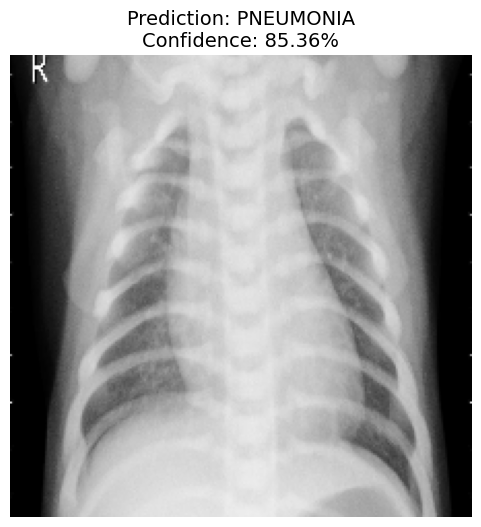

In [33]:

single_image_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])
def predict_single_image(image_path, model, transform, device, class_names):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    transformed = transform(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    pred_class = class_names[pred_idx.item()]
    confidence_score = confidence.item()


    img_display = image_tensor.squeeze().cpu().numpy()
    img_display = (img_display * 0.5) + 0.5
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    return pred_class, confidence_score, img_display

def visualize_prediction(image, prediction, confidence):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {prediction}\nConfidence: {confidence:.2%}", fontsize=14)
    plt.axis('off')
    plt.show()


uploaded = files.upload()
image_path = list(uploaded.keys())[0]


class_names = ['NORMAL', 'PNEUMONIA']


pred_class, confidence, img = predict_single_image(
    image_path=image_path,
    model=model,
    transform=single_image_transform,
    device=device,
    class_names=class_names
)


print(f"\nPrediction: {pred_class}")
print(f"Confidence: {confidence:.2%}")
visualize_prediction(img, pred_class, confidence)
